# Map Clustering


In [ ]:
# !pip install haversine
# !pip install geopy
# !pip install folium

## Baseline

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import scipy.stats as stats
import folium
import itertools
import statistics

import warnings
warnings.filterwarnings("ignore")

In [3]:
addresses = ['서울시 도봉구 방학로6길 25', 
           '서울시 도봉구 덕릉로63길 19',
           '서울시 도봉구 해등로 133',
           '서울시 도봉구 방학로3길 16',
           '서울시 도봉구 도봉로133길 42',
           '서울시 도봉구 덕릉로59나길 20',
           '서울시 도봉구 해등로16가길 32',
           '서울시 도봉구 우이천로34길 38',
           '서울시 도봉구 노해로 41길 9',
           '서울시 도봉구 도봉로 969',
           '서울시 도봉구 방학1동 마들로 656']

In [4]:
def geocoding(address):
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    geo = geolocoder.geocode(address)
    crd = (float(geo.latitude), float(geo.longitude))

    return crd

def geo_df_coding(addresses):
    geo_list = []
    for address in addresses:
        crd = geocoding(address)
        geo_list.append(crd)
    geo_df = pd.DataFrame(geo_list)
    geo_df.columns = ['latitude', 'longitude']
    
    return geo_df

In [5]:
geo_df = geo_df_coding(addresses)
locations = list(zip(geo_df['latitude'], geo_df['longitude']))

In [6]:
# 주소 지점 위치
m = folium.Map(location = [locations[0][0], locations[0][1]], zoom_start=14)

for i in range(len(locations)):
    folium.Marker([float(locations[i][0]), float(locations[i][1])]).add_to(m)
m

## Clustering by only K-Means

### Determination of K

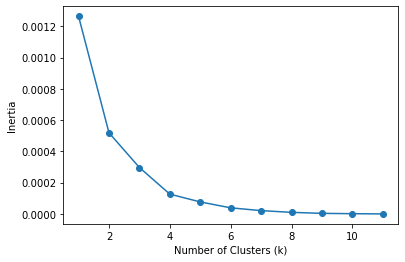

In [7]:

num_clusters = list(range(1,12))
inertias = []

# 각 k별로 모델을 생성하여 inertia를 측정
for i in num_clusters:
    model = KMeans(n_clusters=i, init='k-means++')
    model.fit(geo_df)
    inertias.append(model.inertia_)

# K에 따른 inertia의 변화를 시각화
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel("Inertia")
plt.show()

### K-Means Algorithm

In [10]:
def k_means(geo_df, k):
    geo_df_k = geo_df.copy()
    
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(geo_df)
    labels = model.predict(geo_df.values)
    geo_df_k['labels'] = labels
    
    return geo_df_k

In [20]:
# 중심과 포인트사이 거리(km) 구하는 함수(label 주어졌을 때 사용)
def distance_center(geo_df_k):
    geo_df_k_c = geo_df_k[['latitude', 'longitude', 'labels']].copy()

    # label의 중심점
    # 인덱스와 label이 일치
    center = geo_df_k_c.groupby('labels')[['latitude', 'longitude']].mean().reset_index('labels')[['latitude', 'longitude']]

    for i in range(geo_df_k_c.shape[0]):
        label = geo_df_k_c.loc[i, 'labels']
        geo_df_k_c.loc[i, "distance_center"] = haversine(geo_df_k_c.loc[i,['latitude', 'longitude']], center.loc[label,['latitude', 'longitude']])

    return geo_df_k_c

In [24]:
# k_means clustering 적용
geo_df_2 = k_means(geo_df, 2)
geo_df_3 = k_means(geo_df, 3)
geo_df_4 = k_means(geo_df, 4)
geo_df_5 = k_means(geo_df, 5)
# 각 클러스터의 중심으로부터 거리 계산
geo_df_2 = distance_center(geo_df_2)
geo_df_3 = distance_center(geo_df_3)
geo_df_4 = distance_center(geo_df_4)
geo_df_5 = distance_center(geo_df_5)

In [37]:
print("각 군집의 중심에서 거리들의 합")
print("K=2 : \n{}\n".format(geo_df_2.groupby('labels')['distance_center'].sum()))
print("K=3 : \n{}\n".format(geo_df_3.groupby('labels')['distance_center'].sum()))
print("K=4 : \n{}\n".format(geo_df_4.groupby('labels')['distance_center'].sum()))
print("K=5 : \n{}\n".format(geo_df_5.groupby('labels')['distance_center'].sum()))

각 군집의 중심에서 거리들의 합
K=2 : 
labels
0    3.103646
1    3.950127
Name: distance_center, dtype: float64

K=3 : 
labels
0    3.950127
1    0.214381
2    0.883400
Name: distance_center, dtype: float64

K=4 : 
labels
0    1.669239
1    0.214381
2    0.883400
3    0.337259
Name: distance_center, dtype: float64

K=5 : 
labels
0    1.669239
1    0.214381
2    0.000000
3    0.337259
4    0.000000
Name: distance_center, dtype: float64



### Visualization

In [32]:
def visual_center(geo_df_k):
    labels = geo_df_k['labels']
    locations = geo_df_k.values 
    m = folium.Map(location = [locations[0][0], locations[0][1]], zoom_start=14)

    # 각 위치 분류별로 색 다르게
    for i in range(geo_df_k.shape[0]):
        if (labels[i] == 0):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'blue')).add_to(m)
        elif (labels[i] == 1):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'red')).add_to(m)
        elif (labels[i] == 2):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'green')).add_to(m)
        elif (labels[i] == 3):
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'purple')).add_to(m)
        else:
            folium.Marker([locations[i][0], locations[i][1]], icon=folium.Icon(color = 'black')).add_to(m)

    # 중심 위치
    center = geo_df_k.groupby('labels')[['latitude', 'longitude']].mean().reset_index('labels')[['latitude', 'longitude']]
    for i in range(len(center)):
        folium.CircleMarker(location=[center.loc[i,'latitude'], center.loc[i, 'longitude']],
                            radius=5,
                            color='red',
                            fill_color='red',
                            draggable = False).add_to(m)
    return m

In [33]:
# k=2
visual_center(geo_df_2)

In [34]:
# k=3
visual_center(geo_df_3)

In [35]:
# k=4
visual_center(geo_df_4)

In [36]:
# k=5
visual_center(geo_df_5)

## 각 군집의 중심으로부터 거리 합이 유사한 Clustering Algorithm

In [39]:
def var_diff(geo_df_k):
    diff_list = []

    combinations = list(itertools.combinations(geo_df_k['labels'].unique(), 2))
    distance_sum = geo_df_k.groupby('labels')['distance_center'].sum()

    for i, j in combinations:
        diff = np.abs(distance_sum[i] - distance_sum[j])
        diff_list.append(diff)

    # print("diff_list : {}".format(diff_list))
    # print("variance : {}".format(statistics.variance(diff_list)))
    return statistics.variance(diff_list)

### 1. 각 point를 다른 군집에 포함시킨 후 비교
- 분산은 작아질 수 있음
- 하지만 이런 경우에는 가장 먼 군집에 포함될수도 있어서 적합하지 않아보임


In [41]:
# 첫번째 점에 대해서 다른 군집에 포함시켜봄
geo_df_3_1 = geo_df_3.copy()
geo_df_3_2 = geo_df_3.copy()

geo_df_3_1.loc[0, 'labels'] = (geo_df_3_1.loc[0, 'labels'] + 1)%3
geo_df_3_2.loc[0, 'labels'] = (geo_df_3_2.loc[0, 'labels'] + 2)%3

geo_df_3_1 = distance_center(geo_df_3_1)
geo_df_3_2 = distance_center(geo_df_3_2)

print(var_diff(geo_df_3))
print(var_diff(geo_df_3_1))
print(var_diff(geo_df_3_2))

2.600234317027273
1.9933779525097264
1.3347860181253492


### 2. 다른 군집 중 가장 가까운 point를 해당 군집에 포함시킨 후 거리 합 차이의 분산 비교

- k개의 군집에 대해 각 군집에서 가장 가까운 point 선정
- 그 point를 해당 군집으로 포함시킨 후 중심으로부터의 거리를 구하고 더한 후 군집간의 차이의 분산 측정
- 기존 군집화 모형과, k개의 시도 중 가장 분산이 작은 군집화 모형 선택